# "Quadrant" graphs for 3-bin a/the trends

- Working with the 3-bin data. Eg, say "a" appears `(100, 90, 70)` times in the three bins.
- Represent that as a 2d vector, where the first dimension is the difference in frequency between bins 1 and 2, the second dimension is the difference between bins 2 and 3. So, here - `(-10, -20)`.
- Relativize the values by the total frequency of the word across all 3 bins.
- Do this for all texts, plot on a 2d plane, where the X-axis is the signed difference between bins 1->2, Y-axis is difference between bins 2->3.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [9]:
import bz2
import os
import ujson
import attr
import math

import pandas as pd
import numpy as np

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from collections import OrderedDict, defaultdict
#from pyemd import emd

from sklearn.cluster import AgglomerativeClustering
from scipy import stats

In [10]:
@attr.s
class Dataset:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
    
    def novels(self):
        for path in tqdm_notebook(self.paths()):
            with bz2.open(path) as fh:
                for line in fh:
                    yield ujson.loads(line)

In [11]:
ds = Dataset('../data/top200-3bins.json/')

In [12]:
novels = list(ds.novels())

In [49]:
novels[1000]

{'author_first': 'Collin',
 'author_last': 'Wilcox',
 'chicago_auth_canon': False,
 'chicago_auth_date_b': 1924,
 'chicago_auth_date_d': 1996,
 'chicago_auth_gender': 'M',
 'chicago_auth_geography': 'Detroit, MI; San Francisco, CA',
 'chicago_auth_id': 'A_03621',
 'chicago_auth_nationality': 'American',
 'chicago_auth_race': 'Caucasian',
 'chicago_clean': True,
 'chicago_genre': '',
 'chicago_libraries': 449,
 'chicago_nationality': 'American',
 'chicago_publ_city': 'New York',
 'chicago_publisher': 'T. Doherty Associates',
 'chicago_source': 'k',
 'corpus': 'chicago',
 'counts': {'!': [1, 0, 1],
  '"': [0, 0, 0],
  "'": [0, 0, 0],
  "'s": [1, 0, 0],
  '*': [0, 0, 0],
  ',': [3076, 2953, 3191],
  '-': [200, 198, 216],
  '.': [2332, 2190, 2069],
  ':': [111, 95, 107],
  ';': [17, 14, 12],
  '?': [310, 251, 202],
  'a': [702, 720, 743],
  'about': [86, 104, 96],
  'after': [15, 24, 35],
  'again': [37, 29, 19],
  'all': [78, 60, 89],
  'am': [6, 2, 0],
  'an': [74, 72, 78],
  'and': [437

In [90]:
def plot_quad(token, w=5, h=5, xlim=(-0.2,0.2), ylim=(-0.2,0.2)):
    counts = [np.array(novel['counts'][token]) for novel in novels]
    groups = [novel.get('chicago_auth_gender') for novel in novels]
    selector = set([i for i, (s, c) in enumerate(zip(counts, groups)) 
                    if s.sum() > 100 and c is not None])
    counts = np.stack([s for i, s in enumerate(counts) if i in selector])
    groups = [c == 'M' for i, c in enumerate(groups) if i in selector]

    q1 = np.stack([s for s in counts if s[1]-s[0] <  0 and s[2]-s[1] >= 0])
    q2 = np.stack([s for s in counts if s[1]-s[0] >= 0 and s[2]-s[1] >= 0])
    q3 = np.stack([s for s in counts if s[1]-s[0] <  0 and s[2]-s[1] <  0])
    q4 = np.stack([s for s in counts if s[1]-s[0] >= 0 and s[2]-s[1] <  0])
    
    x, y = [], []
    x_group_a, y_group_a = [], []
    x_group_b, y_group_b = [], []
    for s, c in zip(counts, groups):
        x.append((s[1]-s[0])/s.sum())
        y.append((s[2]-s[1])/s.sum())
        if c:
            x_group_b.append(x[-1])
            y_group_b.append(y[-1])
        else:
            x_group_a.append(x[-1])
            y_group_a.append(y[-1])

    plt.figure(figsize=(w,h))
    plt.axhline(0, c='black', linewidth=1)
    plt.axvline(0, c='black', linewidth=1)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    #plt.scatter(x, y, s=1, alpha=0.8)
    plt.scatter(x_group_a, y_group_a, s=2, color='blue', alpha=0.8)
    plt.scatter(x_group_b, y_group_b, s=2, color='green', alpha=0.8)

    plt.plot([np.mean(x_group_a)], [np.mean(y_group_a)], color='blue', markersize=7, marker='o')
    plt.plot([np.mean(x_group_b)], [np.mean(y_group_b)], color='green', markersize=7, marker='o')

    plt.xlabel('← Falls in first half     Rises in first half →', fontsize=18)
    plt.ylabel('← Falls in second half     Rises in second half →', fontsize=18)
    
    ax = plt.axes([0.15, 0.8, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q1.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q1)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.82, 0.8, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q2.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q2)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.15, 0.14, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q3.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q3)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.82, 0.14, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q4.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q4)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

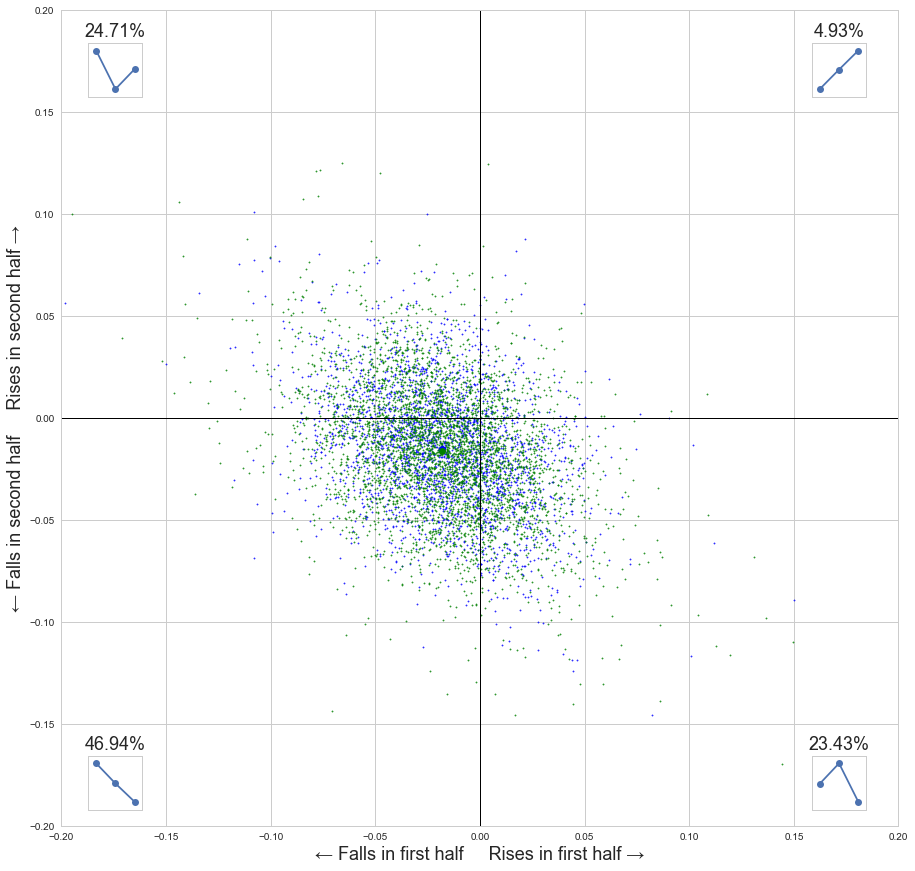

In [92]:
plot_quad('a', 15, 15)

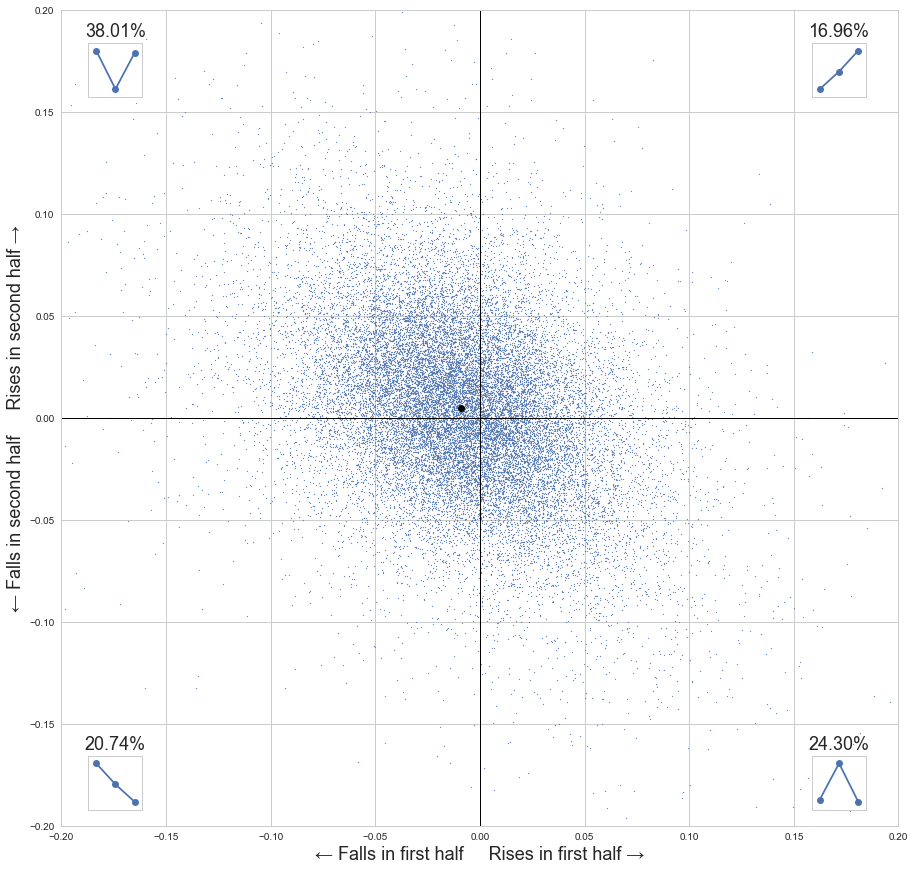

In [15]:
plot_quad('the', 15, 15)

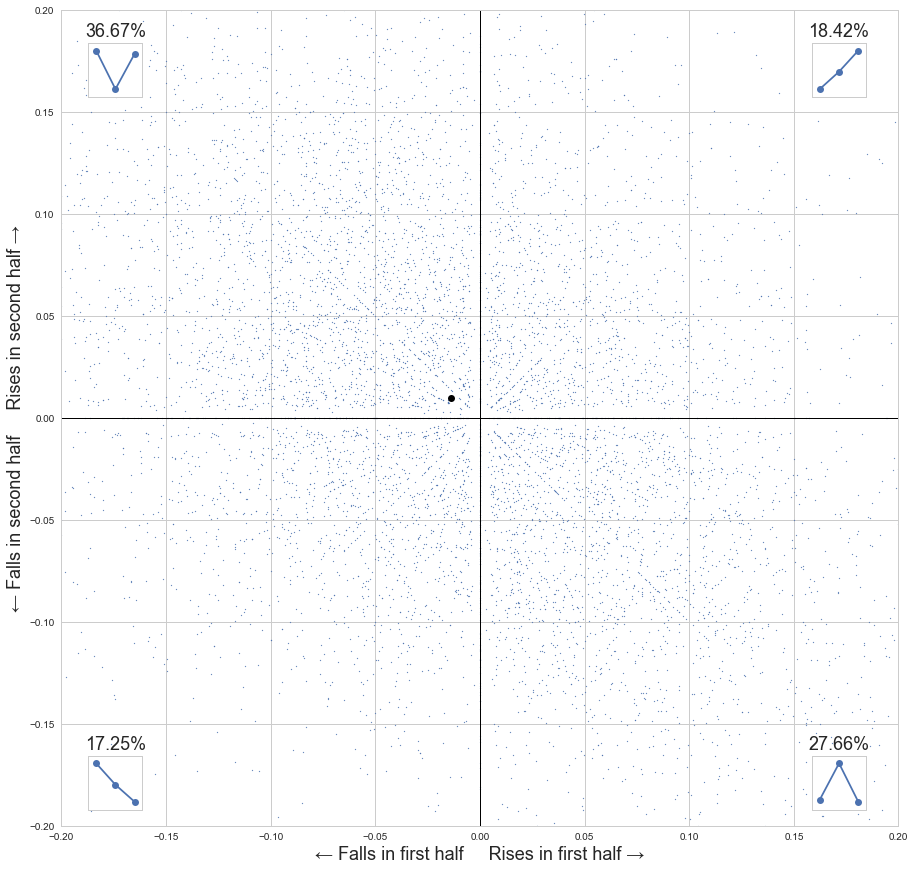

In [27]:
plot_quad('eyes', 15, 15)

In [22]:
novels[0]['counts'].keys()

dict_keys(['been', 'thought', 'about', 'your', 'these', '—', 'would', '‘', 'let', '“', '”', 'you', 'they', '!', '"', 'going', 'old', 'night', "'", 'want', 'them', '*', 'then', ',', 'am', 'an', '-', 'something', '.', 'as', 'himself', 'at', 'left', 'must', ':', ';', 'much', '?', 'be', 'two', 'eyes', 'long', 'how', 'into', 'see', 'are', 'by', 'came', 'where', 'after', 'so', 'hand', 'think', 'a', 'though', 'one', 'i', 'right', 'n’t', 'people', 'the', 'such', 'face', 'to', 'thing', 'did', 'but', 'through', 'had', 'do', 'got', 'down', 'good', 'mother', 'up', 'has', 'us', 'those', 'which', 'last', 'might', 'this', 'its', 'look', 'take', 'she', 'never', 'mrs.', 'once', 'know', 'little', 'some', 'away', 'young', 'father', 'for', 'back', 'house', 'life', 'we', 'not', 'now', 'every', 'just', 'over', 'yes', 'again', 'go', 'was', 'yet', 'way', 'room', 'home', 'with', 'what', 'there', 'well', 'time', 'he', 'very', 'told', 'when', 'her', 'if', '’ll', 'still', 'went', 'in', 'made', 'nothing', 'mr.', '